# Numba Basics

In [2]:
import numba as nb
from numba import njit, jit, vectorize, cuda
from numba.cuda import random # to generate random numbers from cuda
import math
import numpy as np
import cmath
import scipy as sp
import cupy as cp
import time
import matplotlib.pyplot as plt
from skimage import data
import string # for ascii
import requests
from tqdm.auto import trange

In [10]:
@jit(nopython = True)
def hypot(a, b):
    a, b = abs(a), abs(b)
    s, t = max(a, b), min(a, b)
    return s * math.sqrt(1 + ( t / s )**2 )

njit is equivalent to jit(nopython = True)

In [11]:
%timeit hypot(-3,4)

89.4 ns ± 3.56 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [6]:
%timeit hypot.py_func(-3,4)

215 ns ± 7.85 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [7]:
%timeit math.hypot(-3, 4)

54.3 ns ± 1.49 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


## Ex

In [20]:
@jit(nopython=True)
def ex1(x, y, out):
    for i in range(x.shape[0]):
        out[i] = hypot(x[i], y[i])

In [21]:
in1 = np.arange(10, dtype=np.float64)
in2 = 2 * in1 + 1
out = np.empty_like(in1)

print('in1:', in1)
print('in2:', in2)

ex1(in1, in2, out)

print('out:', out)

in1: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
in2: [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]
out: [ 1.          3.16227766  5.38516481  7.61577311  9.8488578  12.08304597
 14.31782106 16.55294536 18.78829423 21.02379604]


In [25]:
np.testing.assert_almost_equal(out, np.hypot(in1, in2))

# CUDA Basics

In [2]:
a = np.arange(1,5)
b = np.arange(10, 50, 10)

In [3]:
np.add(a,b)

array([11, 22, 33, 44])

In [4]:
np.add(a, 100)

array([101, 102, 103, 104])

In [5]:
c = np.arange(1, 17).reshape(4,4)

In [6]:
c

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [7]:
np.add(c, b)

array([[11, 22, 33, 44],
       [15, 26, 37, 48],
       [19, 30, 41, 52],
       [23, 34, 45, 56]])

In [10]:
b_col = b[:, np.newaxis]

In [11]:
np.add(c, b_col)

array([[11, 12, 13, 14],
       [25, 26, 27, 28],
       [39, 40, 41, 42],
       [53, 54, 55, 56]])

## Making ufuncs for the GPU

In [13]:
@vectorize(["int64(int64, int64)"], target = "cuda")
def add_ufunc(x, y):
    return x + y

In [15]:
print(f"a+b:\n {add_ufunc(a,b)}")
print(f"b_col + c:\n {add_ufunc(b_col, c)}")

a+b:
 [11 22 33 44]
b_col + c:
 [[11 12 13 14]
 [25 26 27 28]
 [39 40 41 42]
 [53 54 55 56]]


In [16]:
# NumPy on CPU
%timeit np.add(b_col, c)

710 ns ± 3.59 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [17]:
# Numba on GPU
%timeit add_ufunc(b_col, c)

678 μs ± 38.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats. NumPy defaults to 64-bit data types when creating arrays, so it is important to set the dtype attribute or use the ndarray.astype() method to pick 32-bit types when you need them.

In [3]:
mean = np.float32(0)
sigma = np.float32(1)
size = 1_000_000

In [35]:
%timeit np.random.standard_normal(size = size).astype("float32")

13.2 ms ± 390 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit np.random.normal(loc = mean, scale = sigma, size = size).astype("float32")

14.2 ms ± 376 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
start_time = time.time()
x = cp.random.standard_normal(1_000_000, dtype=cp.float32)
cp.cuda.Stream.null.synchronize()  # wait for GPU computation to finish
end_time = time.time()

cupy_time = end_time - start_time

print("CuPy time:", cupy_time, "seconds")

CuPy time: 0.0008676052093505859 seconds


In [7]:
sqrt_2pi = np.float32(math.sqrt(2*math.pi))

@vectorize(["float32(float32, float32, float32)"], target = "cuda")
def gaussian_pdf(x, mean, sigma):
    f_x = (1 / (sigma * sqrt_2pi)) * math.exp((-0.5)*(((x - mean) / sigma)**2))
    return f_x

In [8]:
x = np.random.uniform(low = -3, high = 3, size = size).astype(np.float32)
gaussian_pdf(x, mean, sigma)

array([0.13688259, 0.28317   , 0.06499455, ..., 0.1473292 , 0.28074467,
       0.3988988 ], shape=(1000000,), dtype=float32)

In [9]:
start_time = time.time()
gaussian_pdf(x, mean, sigma)
cp.cuda.Stream.null.synchronize()  # wait for GPU computation to finish
end_time = time.time()

cupy_time = end_time - start_time

print("CuPy time:", cupy_time, "seconds")

CuPy time: 0.004724264144897461 seconds


In [11]:
%timeit sp.stats.norm.pdf(x, loc = mean, scale = sigma)

10.3 ms ± 153 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## CUDA Device Functions

Device functions are created with the numba.cuda.jit decorator.

They are functions that are only called from other functions running on the GPU.

In [13]:
@cuda.jit(device = True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(["float32(float32, float32, float32, float32)"], target = "cuda")
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    return math.sqrt( ((x1 - x2)**2) + ((y1 - y2)**2) )

In [14]:
n = 10_000_000
rho1 = np.random.uniform(low = 0, high = 10, size = n).astype(np.float32)
theta1 = np.random.uniform(low = -np.pi, high = np.pi, size = n).astype(np.float32)
rho2 = np.random.uniform(low = 0, high = 10, size = n).astype(np.float32)
theta2 = np.random.uniform(low = -np.pi, high = np.pi, size = n).astype(np.float32)

In [15]:
polar_distance(rho1, theta1, rho2, theta2)

array([ 9.36758  ,  3.1324885, 14.435175 , ...,  3.3336263,  3.38633  ,
       10.871541 ], shape=(10000000,), dtype=float32)

In [16]:
start_time = time.time()
polar_distance(rho1, theta1, rho2, theta2)
cp.cuda.Stream.null.synchronize()
end_time = time.time()

print(f"{end_time - start_time} seconds")

0.16499543190002441 seconds


## Ex

In [10]:
n = 1_000_000
noise = np.random.normal(size = n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n/23)) - 0.3, 0)
waveform = ((pulses * 300) + noise).astype(np.int16)

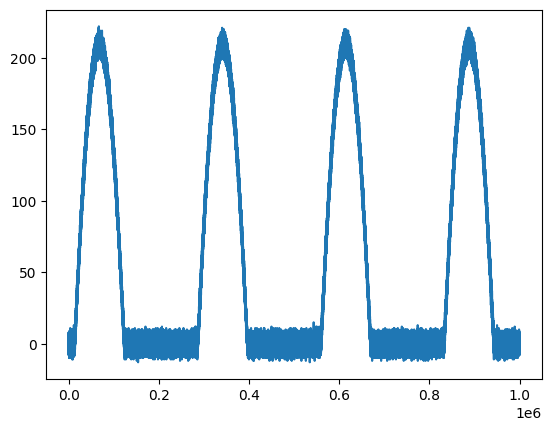

In [18]:
plt.plot(waveform)
plt.show()

In [21]:
@vectorize(["int16(int16, int16)"], target = "cuda")
def zero_suppress(waveform_value, threshold):
    if waveform_value <= threshold:
        waveform_value = 0
    return waveform_value

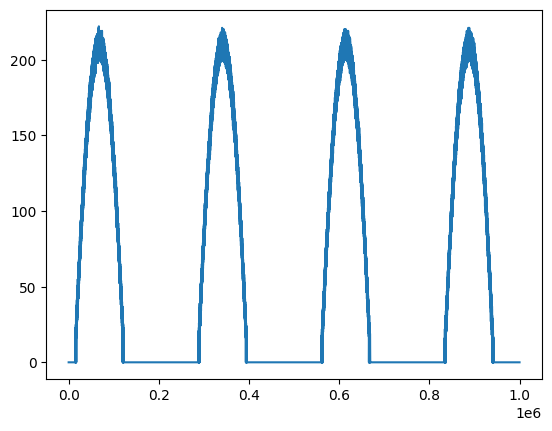

In [23]:
plt.plot(zero_suppress(waveform, 15.0))
plt.show()

# Managing GPU Memory

If you use CuPy arrays, you have to create CuPy kernels to use them.

If you use Numba, then you have to use NumPy arrays and then copy/move those NumPy arrays to the GPU.

In [7]:
@vectorize(["float32(float32, float32)"], target = "cuda")
def add_ufunc(x, y):
    return x + y

In [28]:
n = 1_000_000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [30]:
%timeit add_ufunc(x, y)

3.18 ms ± 60.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

In [34]:
print(x_device)
print(x_device.shape)
print(x_device.dtype)

(1000000,)
float32


In [35]:
%timeit add_ufunc(x_device, y_device)
# the output here is allocated to the host instead of the gpu device
# so the output is created in the gpu and moved to the host

713 μs ± 39.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
out_device = cuda.device_array(shape = (n,), dtype = np.float32)
# this creates an empty array in the gpu device

%timeit add_ufunc(x_device, y_device, out = out_device)
# output is created and kept in gpu device

87.6 μs ± 1.31 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
out_host = out_device.copy_to_host()

## Ex

In [30]:
@vectorize(["float32(float32, float32, float32)"], target = "cuda")
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0) * amplitude

n = 1_000_000
noise = (np.random.normal(size = n) * 3).astype(np.float32)
t = np.arange(n).astype(np.float32)
period = n / 23

In [45]:
t0 = time.perf_counter()

pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

t1 = time.perf_counter()
print(f"{t1 - t0} seconds")

0.014186687999881542 seconds


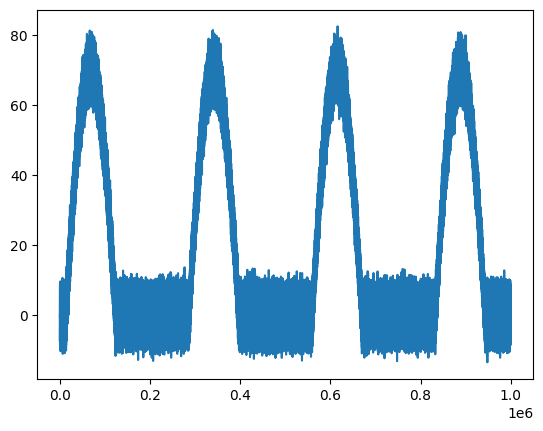

In [32]:
plt.plot(waveform)
plt.show()

In [47]:
t_device = cuda.to_device(t)
noise_device = cuda.to_device(noise)

t0 = time.perf_counter()

pulses_device = make_pulses(t_device, period, 100.0)
waveform_device = add_ufunc(pulses_device, noise_device)

t1 = time.perf_counter()
print(f"{t1 - t0} seconds")

waveform_device = waveform_device.copy_to_host()

0.0025905439997586654 seconds


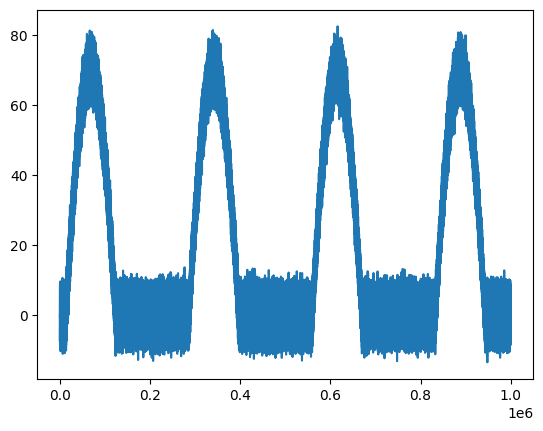

In [48]:
plt.plot(waveform_device)
plt.show()

# Writing CUDA Kernels

Thread Hierarchy

smallest to biggest: threads, blocks, grids

Block size must be a multiple of 32 threads. Usually put between 128 and 512 threads/block

Grid size: Number of blocks/grid should be 2x-4x the number of GPU SM(for rtx 4080 its 76 SMs, so 152 to 304 blocks/grid)

In [2]:
@cuda.jit
def add_kernel(x, y, out):
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x # unique block ID within the 1D block

    block_size = cuda.blockDim.x # number of threads per block
    grid_size = cuda.gridDim.x # number of blocks per grid

    start = tx + ty * block_size 
    # basically, its current global ptn (thread-number within the Block + number of Blocks behind)
    stride = block_size * grid_size

    # assuming x and y inputs are the same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

In [ ]:
# @cuda.jit
# def add_kernel_ver2(x, y, out):
#     tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
#     ty = cuda.blockIdx.x # unique block ID within the 1D block

#     block_size = cuda.blockDim.x # number of threads per block

#     start = tx + ty * block_size 
#     # basically, its current global ptn (thread-number within the Block + number of Blocks behind)

#     # assuming x and y inputs are the same length
#     if start < out.shape[0]:
#         out[start] = x[start] + y[start]

this code (above) is wrong if the total number of threads (blocks_per_grid * threads_per_block = 256 * 128) is less than the size of array. Would leave (the size of array - total threads) number of elements untouched.

In [97]:
@cuda.jit
def add_kernel_ver3(x, y, out):
    start = cuda.grid(1)      # global thread ID in 1D
    stride = cuda.gridsize(1) # total number of threads in 1D grid

    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

ver3 is correct. start is basically tx + ty * cuda.blockDim.x, stride is basically cuda.blockDim.x * cuda.gridDim.x

In [105]:
@cuda.jit
def increment_by_one(x):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(start, x.size, stride):
        x[i] += 1

In [106]:
z = np.arange(1000).astype(np.float32)
increment_by_one[3, threads_per_block](z)

/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:937: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [107]:
z

array([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,
         10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,
         19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,

In [2]:
@cuda.jit
def add_kernel_2D(x, y, out):
    i, j = cuda.grid(2)
    stride_i, stride_j = cuda.gridsize(2)

    for ii in range(i, x.shape[0], stride_i):
        for jj in range(j, x.shape[1], stride_j):
            out[ii, jj] = x[ii, jj] + y[ii, jj]

In [3]:
x = np.random.random(size = (1000, 1000)).astype(np.float32)
y = np.random.random(size = (1000, 1000)).astype(np.float32)
out = np.empty_like(x)

In [12]:
add_kernel_2D[(20,20), (16,16)](x, y, out)
# since x, y are 2d arrays and we initialize cuda.grid(2) and cuda.gridsize(2),
# blocks_per_grid and threads_per_grid must be 2d tuples e.g (20, 20), (16, 16)

In [6]:
x+y

array([[1.4057469 , 0.75533307, 1.4482781 , ..., 0.65442413, 1.9669079 ,
        1.3103855 ],
       [0.7738319 , 0.7384615 , 0.56088686, ..., 1.3944309 , 1.6469831 ,
        1.4724337 ],
       [0.3759542 , 1.7048419 , 1.0782174 , ..., 0.73338133, 0.80771786,
        0.9667431 ],
       ...,
       [1.209758  , 0.9087607 , 0.6365253 , ..., 0.70038354, 0.6612363 ,
        0.8745993 ],
       [0.53438216, 1.4207202 , 0.62317395, ..., 1.3169221 , 0.1937167 ,
        0.03303019],
       [1.2464963 , 1.4674184 , 0.83804405, ..., 1.611311  , 0.86933863,
        1.6684048 ]], shape=(1000, 1000), dtype=float32)

In [5]:
out

array([[1.4057469 , 0.75533307, 1.4482781 , ..., 0.65442413, 1.9669079 ,
        1.3103855 ],
       [0.7738319 , 0.7384615 , 0.56088686, ..., 1.3944309 , 1.6469831 ,
        1.4724337 ],
       [0.3759542 , 1.7048419 , 1.0782174 , ..., 0.73338133, 0.80771786,
        0.9667431 ],
       ...,
       [1.209758  , 0.9087607 , 0.6365253 , ..., 0.70038354, 0.6612363 ,
        0.8745993 ],
       [0.53438216, 1.4207202 , 0.62317395, ..., 1.3169221 , 0.1937167 ,
        0.03303019],
       [1.2464963 , 1.4674184 , 0.83804405, ..., 1.611311  , 0.86933863,
        1.6684048 ]], shape=(1000, 1000), dtype=float32)

In [10]:
np.equal(x+y, out).sum()

np.int64(1000000)

## Memory Access Pattern (Row vs Column Major Order)

In [25]:
@cuda.jit
def add_kernel_2D(x, y, out):
    i, j = cuda.grid(2)
    stride_i, stride_j = cuda.gridsize(2)

    m, n = x.shape
    
    for ii in range(i, m, stride_i):
        for jj in range(j, n, stride_j):
            out[ii, jj] = x[ii, jj] + y[ii, jj]

@cuda.jit
def add_kernel_2D_ver2(x, y, out):
    i, j = cuda.grid(2) # the first dimension is the fastest
    stride_i, stride_j = cuda.gridsize(2)

    m, n = x.shape # here the last (second) dimension is the fastest

    for d0 in range(j, m, stride_j): # we performing on m, so we should index the first dim of out
        for d1 in range(i, n, stride_i):
            out[d0, d1] = x[d0, d1] + y[d0, d1]

blocks_per_grid = (20, 20)
threads_per_block = (16, 16)

x = np.random.random(size = (10_000, 10_000)).astype(np.float32)
y = np.random.random(size = (10_000, 10_000)).astype(np.float32)
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

out1_device = cuda.device_array_like(x_device)
out2_device = cuda.device_array_like(x_device)

In [46]:
add_kernel_2D[blocks_per_grid, threads_per_block](x_device, y_device, out1_device)
cuda.synchronize()

t0 = time.perf_counter()
add_kernel_2D[blocks_per_grid, threads_per_block](x_device, y_device, out1_device)
cuda.synchronize()
t1 = time.perf_counter()
print(f"{t1 - t0} seconds")

0.11834853300024406 seconds


In [47]:
add_kernel_2D_ver2[blocks_per_grid, threads_per_block](x_device, y_device, out2_device)
cuda.synchronize()

t0 = time.perf_counter()
add_kernel_2D_ver2[blocks_per_grid, threads_per_block](x_device, y_device, out2_device)
cuda.synchronize()
t1 = time.perf_counter()
print(f"{t1 - t0} seconds")

0.003782007000154408 seconds


Notice the second version is faster!

In [52]:
(out1_device.copy_to_host() == out2_device.copy_to_host()).mean()

np.float64(1.0)

## Basic Atomic Operations

A race condition occurs when multiple threads read and update the same variable at the same time. This can lead to incorrect results.

Consider this scenario where you want a function such that every thread increases a counter by one

In [54]:
@cuda.jit
def thread_counter_race_condition(counter):
    counter[0] += 1

In [72]:
counter = cuda.to_device(np.zeros(1).astype(np.int32))
thread_counter_race_condition[400, 256](counter)
print(f"Should be {400*256}: {counter.copy_to_host()}")

Should be 102400: [1]


In [75]:
@cuda.jit
def thread_counter_safe(counter):
    # the portion below forces the threads to access the same spot one by one (in series)
    cuda.atomic.add(counter, 0, 1)

In [76]:
counter = cuda.to_device(np.zeros(1).astype(np.int32))
thread_counter_safe[400, 256](counter)
print(f"Should be {400*256}: {counter.copy_to_host()}")

Should be 102400: [102400]


## Ex

In [78]:
def cpu_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    # Note that we don't have to pass in nbins explicitly, because the size of histogram_out determines it
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # This is a very slow way to do this with NumPy, but looks similar to what you will do on the GPU
    for element in x:
        bin_number = np.int32((element - xmin)/bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            # only increment if in range
            histogram_out[bin_number] += 1

In [79]:
x = np.random.normal(size=10000, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

cpu_histogram(x, xmin, xmax, histogram_out)

histogram_out

array([   8,   86,  452, 1577, 2919, 2879, 1570,  437,   64,    7],
      dtype=int32)

In [120]:
@cuda.jit
def cuda_histogram(x, xmin, xmax, histogram_out):
    
    nbins = histogram_out.size
    bin_width = (xmax - xmin) / nbins

    # if you want to print something in the cuda kernel
    if cuda.threadIdx.x == 0 and cuda.blockIdx.x == 0:
        print(f"bin_width =", bin_width) # doesnt support f print
    
    m = cuda.grid(1)
    stride_m = cuda.gridsize(1)

    for i in range(m, x.size, stride_m):
        bin_number = nb.int32( (x[i] - xmin) / bin_width)
        if bin_number >= 0 and bin_number < histogram_out.size:
            cuda.atomic.add(histogram_out, bin_number, 1)

In [121]:
x_device = cuda.to_device(x)
histogram_out_device = cuda.device_array_like(histogram_out)
cuda_histogram[400, 256](x_device, xmin, xmax, histogram_out_device)

bin_width = 0.800000


In [122]:
histogram_out_device.copy_to_host()

array([   8,   86,  452, 1577, 2919, 2879, 1570,  437,   64,    7],
      dtype=int32)

# Extra Topics

## Random Numbers

In [34]:
blocks_per_grid = 400
threads_per_block = 256
rng_states = random.create_xoroshiro128p_states(blocks_per_grid * threads_per_block, seed=1)

This creates an array of size blocks_per_grid * threads_per_block. rng_states[0] corresponds to the rng state for thread 0, rng_states[1] for thread 1 and so on.

In [7]:
@cuda.jit
def compute_pi(rng_states, iterations, out_arr):
    thread_id = cuda.grid(1) # this tells the current thread it is on
    # that thread is responsible for i = thread_id, thread_id + stride, and so on... 
    
    stride = cuda.gridsize(1)

    for i in range(thread_id, iterations, stride):
        x = random.xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = random.xoroshiro128p_uniform_float32(rng_states, thread_id)
        if x**2 + y**2 <= 1:
            out_arr[i] = 1
        else:
            out_arr[i] = 0

In [170]:
x = np.random.uniform(low = -1, high = 1, size = (10_000_000, 2))

In [171]:
(x[:, 0]**2 + x[:, 1]**2 <= 1).mean() * 4

np.float64(3.1418284)

In [172]:
np.pi

3.141592653589793

In [35]:
out_device = cuda.to_device(np.zeros(shape = (100_000_000)).astype(np.float32))
compute_pi[blocks_per_grid, threads_per_block](rng_states, 100_000_000, out_device)

In [36]:
(out_device.copy_to_host()).mean() * 4

np.float32(3.141698)

# Cuda by Numba Examples

## Embarking on a Parallel Journey

In [14]:
moon = data.moon().astype(np.float32) / 255

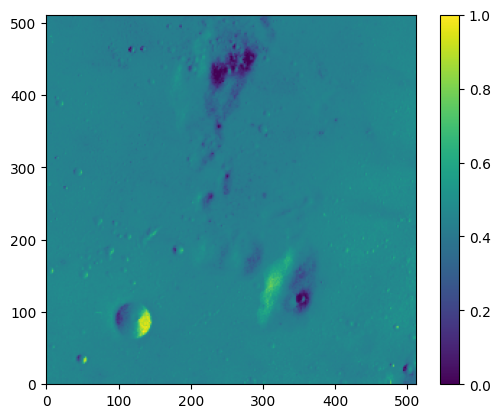

In [15]:
cs = plt.imshow(moon, origin = "lower")
plt.colorbar(cs)
plt.show()

In [19]:
@cuda.jit
def log_correction(image_arr, gain, out_arr):
    x, y = cuda.grid(2)
    stride_x, stride_y = cuda.gridsize(2)

    m, n = image_arr.shape

    for i0 in range(y, m, stride_y):
        for i1 in range(x, n, stride_x):
            out_arr[i0, i1] = gain * math.log2(1 + image_arr[i0, i1])

In [20]:
moon_device = cuda.to_device(moon)
out_device = cuda.device_array_like(moon)

blocks_per_grid = (20, 20)
threads_per_grid = (16, 16)

log_correction[blocks_per_grid, threads_per_grid](moon_device, 1, out_device)
out_host = out_device.copy_to_host()

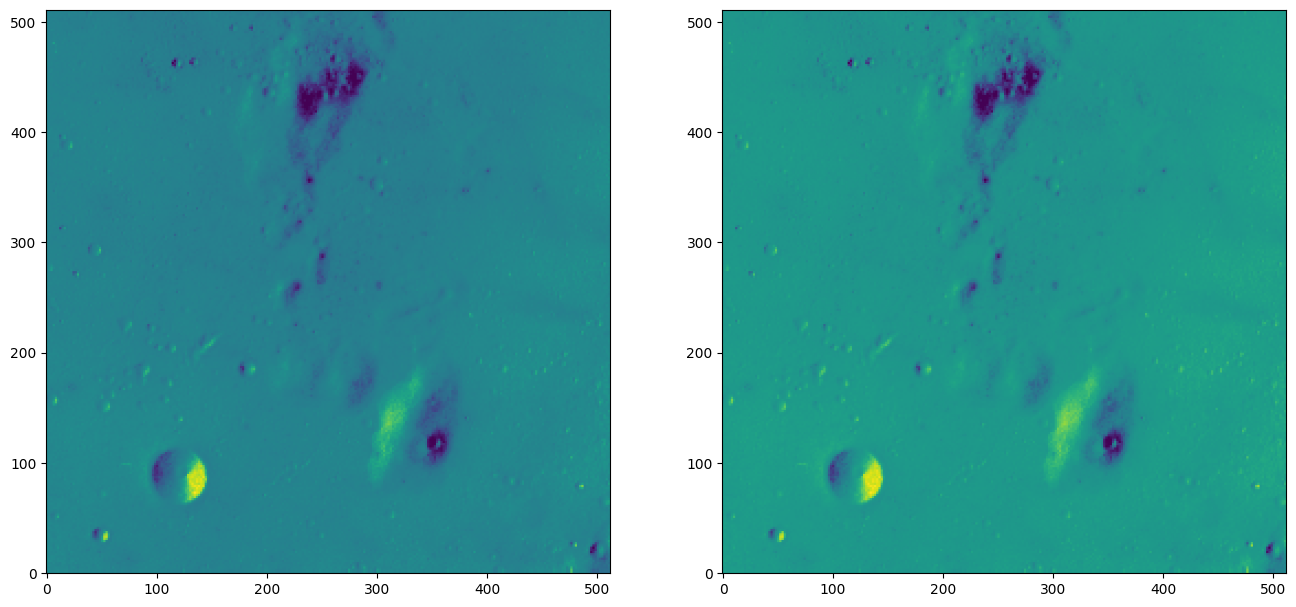

In [34]:
fig = plt.figure(figsize = (16, 9))
ax0 = fig.add_subplot(1, 2, 1)
ax0.imshow(moon, origin = "lower", cmap = 'viridis')
ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(out_host, origin = "lower", cmap = 'viridis')
plt.show()

## Threading the Needle

### Simple Parallel Reduction Algorithm (For Summing elements in an array)

In [3]:
x_gpu = cp.random.normal(loc = 0, scale = 1, size = 1_000_000_000).astype(cp.float32)
x_cpu = cp.asnumpy(x_gpu)

In [4]:
# Simple algorithm for summing elements in an array (cpu, no numpy)

def sum_cpu(array):
    sum = 0
    for i in range(array.size):
        sum += array[i]
    return sum

In [5]:
cp.sum(x_gpu)

array(-41758.484, dtype=float32)

In [6]:
sum_cpu(x_cpu)

np.float32(-41755.992)

In [7]:
x_cpu.sum()

np.float32(-41758.9)

the differences are due to floating float math (refer to MA2213 Numerical Analysis)

To implement summing in CUDA, we need to avoid race conditions, but we also want to avoid using atomic operations (since they force threads to access memory serially, so there's no point using the GPU for calculations).

First, we split the array into chunks. Each chunk corresponds to a block and has a fixed number of threads. Each thread in the block is responsible for summing some elements (may be more than one, since we are using the grid-stride loop). We put these thread values into a shared array (since each thread in the same block can talk to each other) with a length of the number of threads in a block. We then sum all the values in the block into the first element. After that, we put each partial sum into an array of length number of blocks in the grid.

In [8]:
threads_per_block = 1024
blocks_per_grid = 4 * 76

@cuda.jit
def reduce_naive(array, partial_reduction):
    # array is the array we want to sum
    # partial_reduction is the array of partial sums (should be length of blocks_per_grid)
    
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)
    thread_sum = 0.0

    for i in range(thread_idx, array.size, stride):
        thread_sum += array[i]
    
    # here we create the shared array, each block will have its own shared array. It's size must be number of threads_per_blocks.
    s_block = cuda.shared.array(shape = threads_per_block, dtype = nb.float32) # dtype of shared array is numba data type
    # we will block each thread_sum into s_block
    thread_index = cuda.threadIdx.x
    s_block[thread_index] = thread_sum

    cuda.syncthreads()
    # Synchronizes all threads in the same block. They act as a barrier. A barrier for the group of threads means that any threads
    # must stop at this point and cannot continue until every thread in the same block has reach this barrier.

    if thread_index == 0:
        for i in range(1, threads_per_block):
            s_block[0] += s_block[i]
    # this portion the code runs serially^

        block_index = cuda.blockIdx.x
        partial_reduction[block_index] = s_block[0]

In [29]:
res_gpu = cuda.device_array(shape = blocks_per_grid, dtype = np.float32)
reduce_naive[blocks_per_grid, threads_per_block](x_gpu, res_gpu)
cuda.synchronize()


t0 = time.perf_counter()
reduce_naive[blocks_per_grid, threads_per_block](x_gpu, res_gpu)
cuda.synchronize()
t1 = time.perf_counter()
print(f"GPU timing: {t1 - t0} seconds")

t0 = time.perf_counter()
sum_cpu(x_cpu)
t1 = time.perf_counter()
print(f"CPU timing: {t1 - t0} seconds")

GPU timing: 0.007319492999613431 seconds
CPU timing: 75.36611151399984 seconds


We can observe that the code runs serially near the end (the "if" statement portion), we can parallelize this portion by doing the following: 

Consider an example of threads_per_block = 16

We take the first 16/2 = 8 threads. the first thread will sum s_block[0] and s_block[8]. The second thread will sum s_block[1] and s_block[9]... The eighth thread wwill sum s_block[7] and s_block[15].
So the partial summed values are in s_block[0] to s_block[7].

Next we take 8/2 = 4 threads. The first thread will sum s_block[0] and s_block[4]. Second thread will sum ...

Next we take 2 threads. The first thread will sum s_block[0] and s_block[2]...

Next we take 1 thread (the first one). It will sum s_block[0] and s_block[1].

In [9]:
# j = cuda.blockDim.x // 2 # if cuda.BlockDim.x = 512
# while j > 0: # j = 256
#     if thread_index < j: # so if j = 0, it will sum 0th and 256th
#         s_block[thread_index] += s_block[thread_index + j]
#     cuda.syncthreads()
#     j = j//2

# at the second last loop, j = 1. So when it's done, 1//2 = 0 and the while loop ends.

In [9]:
threads_per_block = 1024
blocks_per_grid = 4 * 76

@cuda.jit
def reduce_better(array, partial_reduction):
    # array: array to be summed
    # partial_reduction: array of partially reduced sums, size of blocks_per_grid
    
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    thread_sum = 0.0
    for i in range(thread_idx, array.size, stride):
        thread_sum += array[i]

    s_block = cuda.shared.array(shape = threads_per_block, dtype = nb.float32)
    current_thread = cuda.threadIdx.x
    s_block[current_thread] = thread_sum

    cuda.syncthreads()

    j = cuda.blockDim.x // 2
    while j != 0:
        if current_thread < j:
            s_block[current_thread] += s_block[current_thread + j]
            # if you put the cuda.syncthreads() here, 
            # syncthreads will wait infinitely since only some threads (current_threads < j) call syncthreads
            # if you want to call syncthreads, do it for all threads, not only for certain threads
        cuda.syncthreads()
        j = j // 2

    if current_thread == 0:
        partial_reduction[cuda.blockIdx.x] = s_block[0]

In [10]:
res_better_gpu = cuda.device_array(shape = blocks_per_grid, dtype = np.float32)
reduce_better[blocks_per_grid, threads_per_block](x_gpu, res_better_gpu)

In [11]:
res_better_gpu.copy_to_host().sum()

np.float32(-41758.477)

In [33]:
res_better_gpu = cuda.device_array(shape = blocks_per_grid, dtype = np.float32)
reduce_better[blocks_per_grid, threads_per_block](x_gpu, res_better_gpu)
cuda.synchronize()

t0 = time.perf_counter()
reduce_better[blocks_per_grid, threads_per_block](x_gpu, res_better_gpu)
cuda.synchronize()
t1 = time.perf_counter()
print(f"GPU Better timing: {t1 - t0} seconds")

res_gpu = cuda.device_array(shape = blocks_per_grid, dtype = np.float32)
reduce_naive[blocks_per_grid, threads_per_block](x_gpu, res_gpu)
cuda.synchronize()

t0 = time.perf_counter()
reduce_naive[blocks_per_grid, threads_per_block](x_gpu, res_gpu)
cuda.synchronize()
t1 = time.perf_counter()
print(f"GPU timing: {t1 - t0} seconds")

t0 = time.perf_counter()
sum_cpu(x_cpu)
t1 = time.perf_counter()
print(f"CPU timing: {t1 - t0} seconds")

GPU Better timing: 0.028945051999926363 seconds
GPU timing: 0.007174491999649035 seconds
CPU timing: 67.25450097900011 seconds


In [12]:
reduce_naive[blocks_per_grid, threads_per_block](x_gpu, res_better_gpu)

timing_naive = np.empty(1000)
for i in range(timing_naive.size):
    tic = time.perf_counter()
    reduce_naive[blocks_per_grid, threads_per_block](x_gpu, res_better_gpu)
    s = res_better_gpu.copy_to_host().sum()
    cuda.synchronize()
    toc = time.perf_counter()
    timing_naive[i] = toc - tic
timing_naive *= 10**3

print(f"Elapsed time naive: {timing_naive.mean():.0f} ± {timing_naive.std():.0f} ms")

Elapsed time naive: 8 ± 7 ms


In [13]:
reduce_better[blocks_per_grid, threads_per_block](x_gpu, res_better_gpu)

timing_better = np.empty(1000)
for i in range(timing_better.size):
    tic = time.perf_counter()
    reduce_better[blocks_per_grid, threads_per_block](x_gpu, res_better_gpu)
    s = res_better_gpu.copy_to_host().sum()
    cuda.synchronize()
    toc = time.perf_counter()
    timing_better[i] = toc - tic
timing_better *= 10**3

print(f"Elapsed time better: {timing_better.mean():.0f} ± {timing_better.std():.0f} ms")

Elapsed time better: 8 ± 6 ms


### Numba Reduction

We see that it is not trivial to write a gpu method to sum arrays, so numba has a reduction method that easily does the same thing. WWhat we wrote is not even the fastest method, there's something called Warp Shuffle that skips shared memory (shared memory is expensive!)

In [14]:
@cuda.reduce
def sum_reduce(a, b): 
    return a + b

In [15]:
total_sum = cuda.device_array(shape = 1, dtype = np.float32)
sum_reduce(x_gpu, res = total_sum)
total_sum.copy_to_host()[0]

/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


np.float32(-41758.527)

In [16]:
total_sum = cuda.device_array(shape = 1, dtype = np.float32)

timing_better = np.empty(1000)
for i in range(timing_better.size):
    tic = time.perf_counter()
    sum_reduce(x_gpu, res = total_sum)
    s = total_sum.copy_to_host()[0]
    cuda.synchronize()
    toc = time.perf_counter()
    timing_better[i] = toc - tic
timing_better *= 10**3

print(f"Elapsed time: {timing_better.mean():.0f} ± {timing_better.std():.0f} ms")

Elapsed time: 13 ± 6 ms


### Example

In [136]:
blocks_per_grid_2d = (20, 20)
threads_per_block_2d = (32, 32)

shape = int(np.prod(threads_per_block_2d))

@cuda.jit
def reduce_array_2d(array2d, partial_sum2d):
    thread_idx_x, thread_idx_y = cuda.grid(2)
    stride_x, stride_y = cuda.gridsize(2)
    
    thread_sum = 0.0
    for i in range(thread_idx_y, array2d.shape[0], stride_y):
        for j in range(thread_idx_x, array2d.shape[1], stride_x):
            thread_sum += array2d[i, j]

    s_block = cuda.shared.array(shape = shape, dtype = nb.float32)
    current_thread = cuda.threadIdx.x + cuda.threadIdx.y * cuda.blockDim.x
    s_block[current_thread] = thread_sum
    cuda.syncthreads()

    size = cuda.blockDim.x * cuda.blockDim.y // 2
    while size != 0:
        if current_thread < size:
            s_block[current_thread] += s_block[current_thread + size]
        cuda.syncthreads()
        size //= 2
    
    if current_thread == 0:
    # basically just need one thread to write this part
        partial_sum2d[cuda.blockIdx.x, cuda.blockIdx.y] = s_block[0]

In [117]:
# """
# 0, 1, 2
# 3, 4, 5
# 6, 7, 8
# 9, 10, 11
# 12, 13, 14

# blockDim.x = 3, blockDim.y = 5
# for 7, threadIdx is (1, 2)
# so currentIdx = threadIdx.x + blockDim.x * threadIdx.y ( 7 = 1 + 3*2 )
# """

In [119]:
y_gpu = cp.random.standard_cauchy(size = (10_000, 100_000), dtype = cp.float32)

In [133]:
y_gpu.sum()

array(6.9032845e+08, dtype=float32)

In [137]:
y_sum = cuda.device_array(shape = blocks_per_grid_2d, dtype = np.float32)
reduce_array_2d[blocks_per_grid_2d, threads_per_block_2d](y_gpu, y_sum)

In [141]:
y_sum.copy_to_host().sum() / (10**8)

np.float32(6.9032845)

## Streams and Events

### Normalize an array with the sum

In [2]:
blocks_per_grid = 4 * 76
threads_per_block = 1024

@cuda.jit
def partial_reduce(array, partial_reduction):
    thread_index = cuda.grid(1)
    stride = cuda.gridsize(1)

    thread_sum = 0.0
    for i in range(thread_index, array.size, stride):
        thread_sum += array[i]
    
    current_thread = cuda.threadIdx.x
    s_block = cuda.shared.array(shape = threads_per_block, dtype = nb.float32)
    s_block[current_thread] = thread_sum

    cuda.syncthreads()

    j = cuda.blockDim.x // 2
    while j != 0:
        if current_thread < j:
            s_block[current_thread] += s_block[current_thread + j]
        cuda.syncthreads()
        j //= 2

    if current_thread == 0:
        partial_reduction[cuda.blockIdx.x] = s_block[0]

@cuda.jit
def single_thread_sum(partial_reduction, sum):
    sum[0] = 0.0
    for element in partial_reduction:
        sum[0] += element

@cuda.jit
def divide_by(array, sum):
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(thread_idx, array.size, stride):
        array[i] = array[i] / sum[0]

In [26]:
x_cpu = np.ones(shape = 10_000_000, dtype = np.float32)
print(f"Sum: {x_cpu.sum():.1f}") #:.1f sets the precision to 1d.p

with cuda.pinned(x_cpu):
    
    stream = cuda.stream() 
    # creates a cuda stream

    x_gpu = cuda.to_device(x_cpu, stream = stream)
    partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
    sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)
    # note need to put stream inside the gpu arrays

    partial_reduce[blocks_per_grid, threads_per_block, stream](x_gpu, partial_sum_gpu)
    single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
    divide_by[blocks_per_grid, threads_per_block, stream](x_gpu, sum_gpu)
    # for kernels, put stream after the threads_per_block

    x_gpu.copy_to_host(x_cpu, stream = stream)

stream.synchronize()
# this stream.synchronize() ensures that the operations in the stream are done and transfered back to host
# basically the CPU waits for the GPU's stream to be done

print(f"Normalized Sum: {x_cpu.sum():.1f}")


Sum: 10000000.0
Normalized Sum: 1.0


/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
# alternatively, instead of manually calling stream.synchronize() you can do stream.auto_synchronize() in the following way

x_cpu = np.ones(shape = 10_000_000, dtype = np.float32)
print(f"Sum: {x_cpu.sum():.1f}") #:.1f sets the precision to 1d.p, put inside the {} 

with cuda.pinned(x_cpu):
    
    stream = cuda.stream() 
    # creates a cuda stream

    with stream.auto_synchronize():
    # stream.auto_synchronize() will do the synchronization for you when you exit the 
    # stream.auto_synchronize() block
    # this happens even if an error occurs in the block

        x_gpu = cuda.to_device(x_cpu, stream = stream)
        partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
        sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)
        # note need to put stream inside the gpu arrays

        partial_reduce[blocks_per_grid, threads_per_block, stream](x_gpu, partial_sum_gpu)
        single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
        divide_by[blocks_per_grid, threads_per_block, stream](x_gpu, sum_gpu)
        # for kernels, put stream after the threads_per_block

        x_gpu.copy_to_host(x_cpu, stream = stream)


print(f"Normalized Sum: {x_cpu.sum():.1f}")

Sum: 10000000.0
Normalized Sum: 1.0


/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


### Normalizing 10 different arrays using different streams

In [8]:
# This uses multiple streams!

N_streams = 10

with cuda.defer_cleanup(): # prevents Numba from automatically freeing GPU memory
# this basically tells Numba not to delete any GPU array until the block is done
    stream_arr = [cuda.stream() for _ in range(N_streams)]
    arr_lst = [np.random.standard_normal(10_000_000).astype(np.float32) for _ in range(N_streams)]

    for i, arr in enumerate(arr_lst):
        print(f"Array {i}: {arr.sum():.2f}")
    
    tics = []
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        tic = time.perf_counter() # time start
        tics.append(tic)

        with cuda.pinned(arr):    
            arr_gpu = cuda.to_device(arr, stream = stream)
            partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
            sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](arr_gpu, partial_sum_gpu)
            single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
            divide_by[blocks_per_grid, threads_per_block, stream](arr_gpu, sum_gpu)

            arr_gpu.copy_to_host(arr, stream = stream)
        
        toc = time.perf_counter()
        print(f"Launched processing in {i} in {toc - tic} seconds")
        # the difference between tic measures how fast the cpu launched the kernel

        del arr_gpu, partial_sum_gpu, sum_gpu
        # this reduces the python references to 0 (refcount = 0)
        # so when the kernel is done using them, the gpu will free up the memory 
        # outside the pinned block, within the for loop

    tocs = []
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        stream.synchronize() 
        # syncfronize() is not put in the initial loop as it would force the normalisations to run serially

        toc = time.perf_counter()
        tocs.append(toc)
        
        print(f"Finished Processing array {i} in {tocs[i] - tics[i]} seconds")
        # this measures how long it took to finish normalizing the arrays
        
        print(f"New value of arr {i}: {arr.sum():.2f}")

    print(f"Total time taken: {tocs[-1] - tics[0]} seconds")
            

Array 0: 2962.19
Array 1: 2248.03
Array 2: -6224.47
Array 3: 2791.21
Array 4: -690.15
Array 5: 3939.85
Array 6: 1303.50
Array 7: -263.79
Array 8: 1055.76
Array 9: 3971.32
Launched processing in 0 in 0.023495453000123234 seconds
Launched processing in 1 in 0.02341058100000737 seconds
Launched processing in 2 in 0.02172635299984904 seconds
Launched processing in 3 in 0.02564574400003039 seconds
Launched processing in 4 in 0.02535708200002773 seconds
Launched processing in 5 in 0.02753808899979049 seconds
Launched processing in 6 in 0.02323047999971095 seconds
Launched processing in 7 in 0.021338606999961485 seconds
Launched processing in 8 in 0.021648833999734052 seconds
Launched processing in 9 in 0.021496893999938038 seconds
Finished Processing array 0 in 0.2353795839999293 seconds
New value of arr 0: 1.00
Finished Processing array 1 in 0.21328394900001513 seconds
New value of arr 1: 1.00
Finished Processing array 2 in 0.19134399599988683 seconds
New value of arr 2: 1.00
Finished Proce

In [9]:
# This uses one stream! So everything runs serially

N_streams = 10

with cuda.defer_cleanup():
    stream_arr = [cuda.stream()] * N_streams
    # same stream for all 10 arrays
    arr_lst = [np.random.standard_normal(size = 10_000_000).astype(np.float32) for _ in range(N_streams)]

    for i, arr in enumerate(arr_lst):
        print(f"Array {i}: {arr.sum():.2f}")
    
    tics = []
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        tic = time.perf_counter()
        tics.append(tic)
    
        with cuda.pinned(arr):
            arr_gpu = cuda.to_device(arr, stream = stream)
            partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
            sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](arr_gpu, partial_sum_gpu)
            single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
            divide_by[blocks_per_grid, threads_per_block, stream](arr_gpu, sum_gpu)

            arr_gpu.copy_to_host(arr, stream = stream)
        
        del arr_gpu, partial_sum_gpu, sum_gpu
        toc = time.perf_counter()
        print(f"Launched processing in {i} in {toc - tic} seconds")

    tocs = []
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        stream.synchronize()
        toc = time.perf_counter()
        tocs.append(toc)
        print(f"Finished Processing array {i} in {tocs[i] - tics[i]} seconds")
        print(f"New value of arr {i}: {arr.sum():.2f}")

    print(f"Total time taken: {tocs[-1] - tics[0]} seconds")


Array 0: 1031.15
Array 1: -6492.70
Array 2: 747.03
Array 3: -3403.44
Array 4: -1514.11
Array 5: -3297.35
Array 6: 3541.55
Array 7: -2333.43
Array 8: -2647.83
Array 9: -436.65
Launched processing in 0 in 0.02433867799982181 seconds
Launched processing in 1 in 0.023816514999907668 seconds
Launched processing in 2 in 0.022042205999696307 seconds
Launched processing in 3 in 0.022848680000151944 seconds
Launched processing in 4 in 0.02544462600008046 seconds
Launched processing in 5 in 0.02402294500006974 seconds
Launched processing in 6 in 0.02357606899977327 seconds
Launched processing in 7 in 0.0231303730001855 seconds
Launched processing in 8 in 0.022536730999945576 seconds
Launched processing in 9 in 0.0278281490000154 seconds
Finished Processing array 0 in 0.23987763400009499 seconds
New value of arr 0: 1.00
Finished Processing array 1 in 0.217098993000036 seconds
New value of arr 1: 1.00
Finished Processing array 2 in 0.19478490499977852 seconds
New value of arr 2: 1.00
Finished Proc

### Timing Kernel Execution

In [17]:
event_start = cuda.event()
event_end = cuda.event()

stream = cuda.stream()

arr = np.random.standard_normal(size = 10_000_000).astype(np.float32)

with cuda.pinned(arr):
    arr_gpu = cuda.to_device(arr, stream = stream)
    partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
    sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)

    event_start.record(stream = stream) # this starts recording

    partial_reduce[blocks_per_grid, threads_per_block, stream](arr_gpu, partial_sum_gpu)
    single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
    divide_by[blocks_per_grid, threads_per_block, stream](arr_gpu, sum_gpu)

    event_end.record(stream = stream) # records the ending time

    event_end.wait(stream = stream)
    # this code tells that particular stream to wait until event_end is recorded
    # anything after event_end.wait(stream = stream) cannot run until event_end.record(stream = stream) is done
    # this code is redundant if we are working in the same stream
    # within the same stream, execuation order is done as given by the code

    event_end.synchronize()
    # we do event_end.synchronize here to ensure that CPU only waits for event_end to be done
    # if we do stream.synchronize(), CPU will wiat for everything in the stream is done (can be more than just event_end)

timing_ms = event_start.elapsed_time(event_end)
# timing given is in ms
# start.elapsed_time(end)

print(f"Kernel execution done in {timing_ms} ms")


Kernel execution done in 3.72544002532959 ms


### Events for timing streams

In [13]:
# timing multiple streams 

N_streams = 10

with cuda.defer_cleanup():
    stream_arr = [cuda.stream() for _ in range(N_streams)]
    arr_lst = [np.random.standard_normal(size = 50_000_000).astype(np.float32) for _ in range(N_streams)]

    event_start_lst = []
    event_end_lst = []
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        with cuda.pinned(arr):
            event_start = cuda.event()
            event_end = cuda.event()

            event_start.record(stream = stream)
            
            arr_gpu = cuda.to_device(arr, stream = stream)
            partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
            sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](arr_gpu, partial_sum_gpu)
            single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
            divide_by[blocks_per_grid, threads_per_block, stream](arr_gpu, sum_gpu)
            
            arr_gpu.copy_to_host(arr, stream = stream)
            event_end.record(stream = stream)
            
        event_start_lst.append(event_start)
        event_end_lst.append(event_end)

        del arr_gpu, partial_sum_gpu, sum_gpu

time.sleep(10) # this ensures all the kernels are completed
for event_end in event_end_lst:
    event_end.synchronize() # this synchronizes each stream

elapsed_times_lst = [event_start_lst[0].elapsed_time(event_end) for event_end in event_end_lst]
last_stream_finished = np.argmax(elapsed_times_lst)

print(f"The last stream finished is {last_stream_finished} at {elapsed_times_lst[last_stream_finished]} ms")




The last stream finished is 9 at 1023.8258056640625 ms


In [ ]:
# One stream only

N_streams = 10

with cuda.defer_cleanup():
    stream_arr = [cuda.stream()] * N_streams
    arr_lst = [np.random.standard_normal(size = 50_000_000).astype(np.float32) for _ in range(N_streams)]

    event_start_lst = []
    event_end_lst = []
    
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        with cuda.pinned(arr):
            event_start = cuda.event()
            event_end = cuda.event()

            event_start.record(stream = stream)

            arr_gpu = cuda.to_device(arr, stream = stream)
            partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
            sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](arr_gpu, partial_sum_gpu)
            single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
            divide_by[blocks_per_grid, threads_per_block, stream](arr_gpu, sum_gpu)

            arr_gpu.copy_to_host(arr, stream = stream)
            
            event_end.record(stream = stream)
        
        event_start_lst.append(event_start)
        event_end_lst.append(event_end)
        del arr_gpu, partial_sum_gpu, sum_gpu

time.sleep(10)
for event_end in event_end_lst:
    event_end.synchronize()

elapsed_times_lst = [event_start_lst[0].elapsed_time(event_end) for event_end in event_end_lst]
last_stream_finished = np.argmax(elapsed_times_lst)

print(f"The last stream finished is {last_stream_finished} at {elapsed_times_lst[last_stream_finished]} ms")

/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


The last stream finished is 9 at 1078.539794921875 ms


Can replace event_end.synchronize() with a global cuda.synchronize()

In [7]:
# timing multiple streams 

N_streams = 5

with cuda.defer_cleanup():
    stream_arr = [cuda.stream() for _ in range(N_streams)]
    arr_lst = [np.random.standard_normal(size = 50_000_000).astype(np.float32) for _ in range(N_streams)]

    event_start_lst = []
    event_end_lst = []
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        with cuda.pinned(arr):
            event_start = cuda.event()
            event_end = cuda.event()

            event_start.record(stream = stream)
            
            arr_gpu = cuda.to_device(arr, stream = stream)
            partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
            sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](arr_gpu, partial_sum_gpu)
            single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
            divide_by[blocks_per_grid, threads_per_block, stream](arr_gpu, sum_gpu)
            
            arr_gpu.copy_to_host(arr, stream = stream)
            event_end.record(stream = stream)
            
        event_start_lst.append(event_start)
        event_end_lst.append(event_end)

        del arr_gpu, partial_sum_gpu, sum_gpu

cuda.synchronize()

elapsed_times_lst = [event_start_lst[0].elapsed_time(event_end) for event_end in event_end_lst]
last_stream_finished = np.argmax(elapsed_times_lst)

print(f"The last stream finished is {last_stream_finished} at {elapsed_times_lst[last_stream_finished]} ms")




The last stream finished is 4 at 296.693115234375 ms


In [8]:
# One stream only

N_streams = 5

with cuda.defer_cleanup():
    stream_arr = [cuda.stream()] * N_streams
    arr_lst = [np.random.standard_normal(size = 50_000_000).astype(np.float32) for _ in range(N_streams)]

    event_start_lst = []
    event_end_lst = []
    
    for i, (stream, arr) in enumerate(zip(stream_arr, arr_lst)):
        with cuda.pinned(arr):
            event_start = cuda.event()
            event_end = cuda.event()

            event_start.record(stream = stream)

            arr_gpu = cuda.to_device(arr, stream = stream)
            partial_sum_gpu = cuda.device_array(blocks_per_grid, dtype = np.float32, stream = stream)
            sum_gpu = cuda.device_array(1, dtype = np.float32, stream = stream)

            partial_reduce[blocks_per_grid, threads_per_block, stream](arr_gpu, partial_sum_gpu)
            single_thread_sum[1, 1, stream](partial_sum_gpu, sum_gpu)
            divide_by[blocks_per_grid, threads_per_block, stream](arr_gpu, sum_gpu)

            arr_gpu.copy_to_host(arr, stream = stream)
            
            event_end.record(stream = stream)
        
        event_start_lst.append(event_start)
        event_end_lst.append(event_end)
        del arr_gpu, partial_sum_gpu, sum_gpu

cuda.synchronize()

elapsed_times_lst = [event_start_lst[0].elapsed_time(event_end) for event_end in event_end_lst]
last_stream_finished = np.argmax(elapsed_times_lst)

print(f"The last stream finished is {last_stream_finished} at {elapsed_times_lst[last_stream_finished]} ms")

The last stream finished is 4 at 347.0688171386719 ms


## Atomics 

In [2]:
def str_to_arr(x):
    return np.frombuffer(bytes(x, "utf-8"), dtype = np.uint8)

def grab_uppercase(x):
    return x[65: 65 + 26]

def grab_lowercase(x):
    return x[97: 97 + 26]

In [28]:
str_to_arr("Numba is difficult to learn!")

array([ 78, 117, 109,  98,  97,  32, 105, 115,  32, 100, 105, 102, 102,
       105,  99, 117, 108, 116,  32, 116, 111,  32, 108, 101,  97, 114,
       110,  33], dtype=uint8)

In [4]:
histo_np, bin_edges = np.histogram(str_to_arr("Numba is difficult to learn!"), bins=128, range=(0, 128))
print(histo_np) # count of each ascii character
print(bin_edges) # this corresponds to the ascii table, for example number 65 is "A"

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 2 0 0 3 0 0 2 1 1
 1 0 0 1 1 2 2 0 0 0 0 0 0 0 0 0 0]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128.]


In [36]:
grab_lowercase(histo_np), grab_lowercase(bin_edges)

(array([2, 1, 1, 1, 1, 2, 0, 0, 3, 0, 0, 2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0,
        0, 0, 0, 0]),
 array([ 97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
        119., 120., 121., 122.]))

In [3]:
def ascii_histo(ascii_val_arr):
    fig = plt.figure(figsize = (16, 18))
    ascii_arr = np.arange(start = 0 , stop = 128)
    max_count = np.max(np.concat((grab_lowercase(ascii_val_arr), grab_uppercase(ascii_val_arr))))
    
    ax0 = fig.add_subplot(2, 1, 2)
    ax0.bar(grab_lowercase(ascii_arr), grab_lowercase(ascii_val_arr))
    ax0.set_title("Lowercase")
    ax0.set_ylabel("Count")
    ax0.set_ylim((0, max_count+1))
    ax0.set_xticks(ticks = grab_lowercase(ascii_arr), labels = list(string.ascii_lowercase))

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.bar(grab_uppercase(ascii_arr), grab_uppercase(ascii_val_arr))
    ax1.set_title("Uppercase")
    ax1.set_ylabel("Count")
    ax1.set_ylim((0, max_count+1))
    ax1.set_xticks(ticks = grab_uppercase(ascii_arr), labels = list(string.ascii_uppercase))
    
    plt.show()

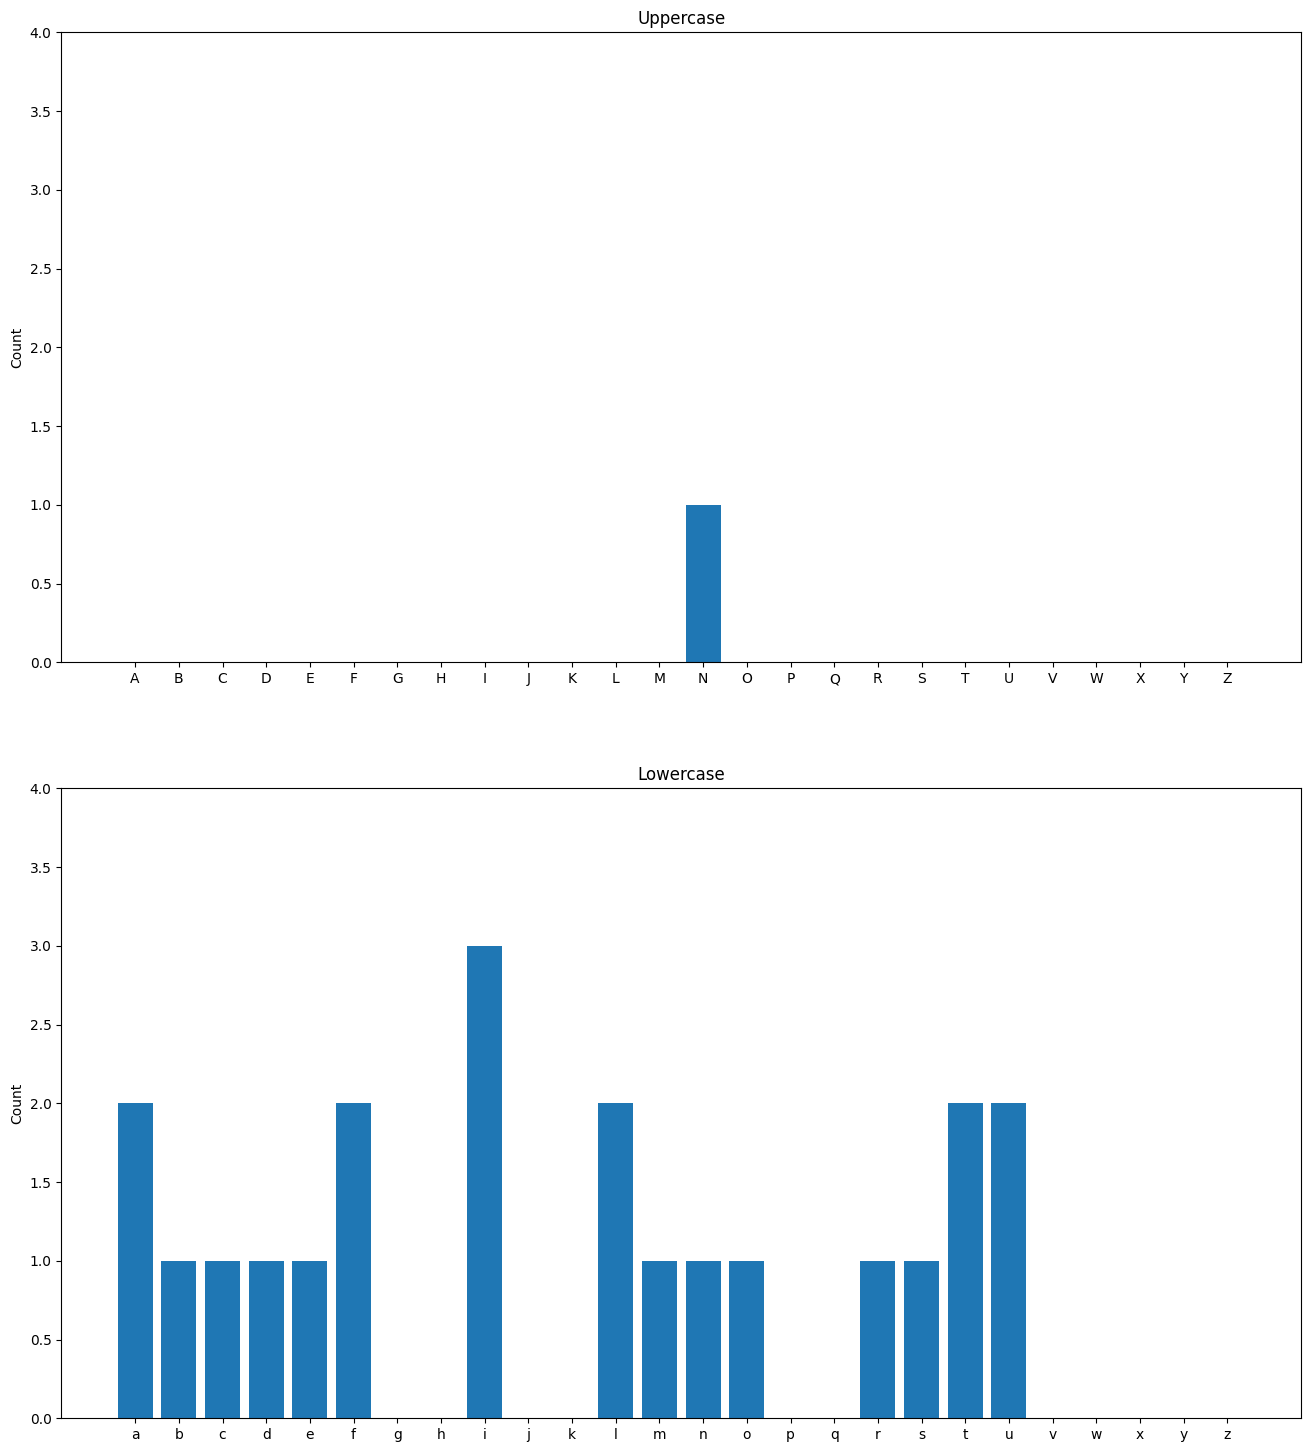

In [8]:
ascii_histo(histo_np)

In [19]:
# implement our own cpu version of counting 

def ascii_count_histogram_cpu(str_in_ascii_arr):
    ascii_val_arr = np.zeros(shape = 128, dtype = np.int64)
    for char in str_in_ascii_arr:
        if char < 128:
            ascii_val_arr[char] += 1
    return ascii_val_arr
    

In [10]:
ascii_count_histogram_cpu(str_to_arr("Numba is difficult to learn!"))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 0, 0, 3, 0, 0, 2, 1,
       1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [4]:
@cuda.jit
def ascii_kernel(ascii_val_arr):
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(thread_idx, ascii_val_arr.size, stride):
        ascii_val_arr[i] = 0

@cuda.jit
def ascii_count_histogram_gpu(str_in_ascii_arr, ascii_val_arr):
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(thread_idx, str_in_ascii_arr.size, stride):
        if str_in_ascii_arr[i] < 128:
            cuda.atomic.add(ascii_val_arr, str_in_ascii_arr[i], 1)

In [12]:
str_ascii_cpu = str_to_arr("Numba is difficult to learn!")
str_ascii_gpu = cuda.to_device(str_ascii_cpu)

ascii_val_arr_gpu = cuda.device_array(shape = 128, dtype = np.int32)

In [13]:
ascii_kernel[1, 128](ascii_val_arr_gpu)
ascii_count_histogram_gpu[4*76, 1024](str_ascii_gpu, ascii_val_arr_gpu)

ascii_val_arr_cpu = ascii_val_arr_gpu.copy_to_host()
cuda.synchronize()

/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


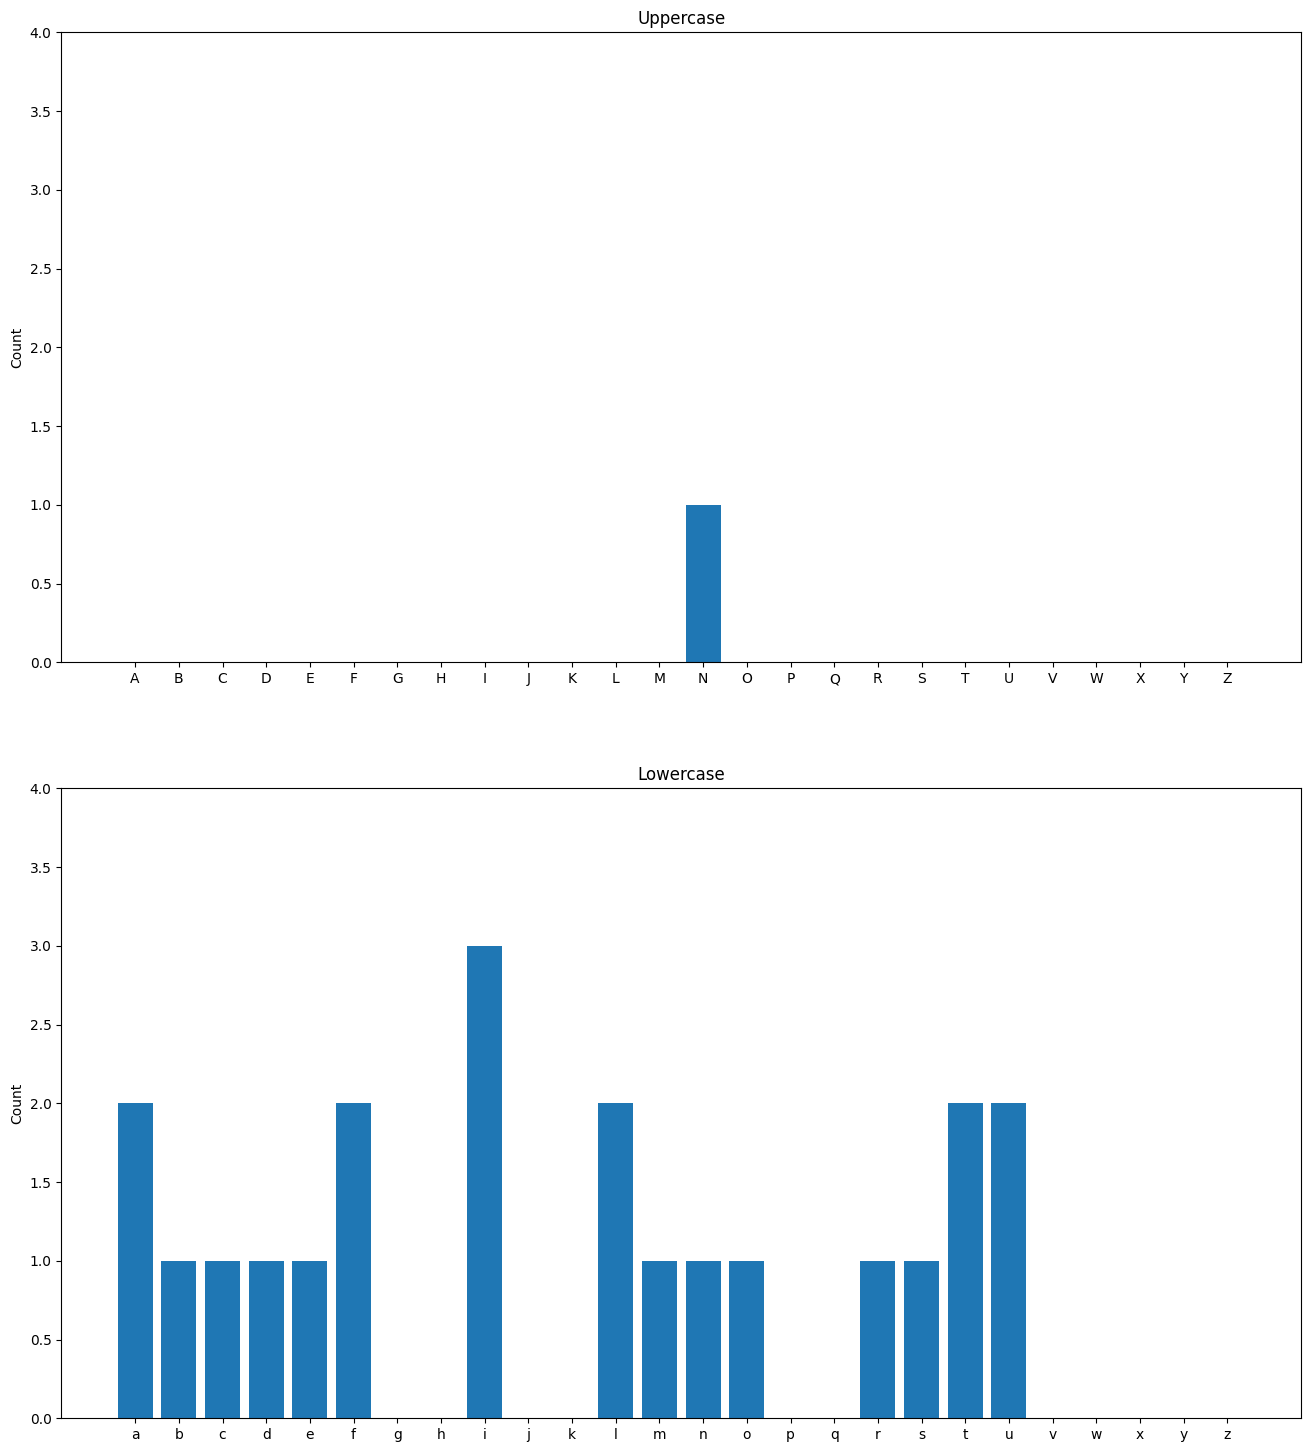

In [15]:
ascii_histo(ascii_val_arr_cpu)

### Example

In [11]:
URL = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
response = requests.get(URL)
str_bill = response.text

str_bill_arr = str_to_arr(str_bill)

In [17]:
n = 10
elapsed_np = 0.0
for _ in trange(n):
    tic = time.perf_counter()
    np.histogram(str_bill_arr, bins = 128, range = (0, 128))
    toc = time.perf_counter()
    time_taken_np = (toc - tic) * (10**3) # converts to ms
    elapsed_np += time_taken_np
mean_elapsed_np = elapsed_np / n

100%|██████████| 10/10 [00:00<00:00, 29.39it/s]


In [22]:
mean_elapsed_np

33.84159099998669

In [23]:
n = 10
elapsed_cpu = 0.0
for _ in trange(n):
    tic = time.perf_counter()
    ascii_count_histogram_cpu(str_bill_arr)
    toc = time.perf_counter()
    time_taken_cpu = (toc - tic) * (10**3)
    elapsed_cpu += time_taken_cpu
mean_elapsed_cpu = elapsed_cpu / n

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


In [24]:
mean_elapsed_cpu

929.6155237000221

In [37]:
mean_elapsed_gpu

2.9746166467666626

In [45]:
blocks_per_grid = 32 * 76
threads_per_block = 128

str_bill_arr_gpu = cuda.to_device(str_bill_arr)
ascii_val_arr_gpu = cuda.device_array(shape = 128, dtype = np.int64)
stream = cuda.stream()

n = 10000
event_start_lst = []
event_end_lst = []
for _ in trange(n):
    event_start = cuda.event()
    event_end = cuda.event()
    event_start.record(stream = stream)
    ascii_kernel[1, 128, stream](ascii_val_arr_gpu)
    ascii_count_histogram_gpu[blocks_per_grid, threads_per_block, stream](str_bill_arr_gpu, ascii_val_arr_gpu)
    event_end.record(stream = stream)

    event_start_lst.append(event_start)
    event_end_lst.append(event_end)
stream.synchronize()
elapsed_gpu_lst = [e0.elapsed_time(e1) for (e0, e1) in list(zip(event_start_lst, event_end_lst))]
mean_elapsed_gpu = np.mean(elapsed_gpu_lst)

100%|██████████| 10000/10000 [00:19<00:00, 517.21it/s]


In [48]:
mean_elapsed_gpu

np.float64(1.9915780563354493)

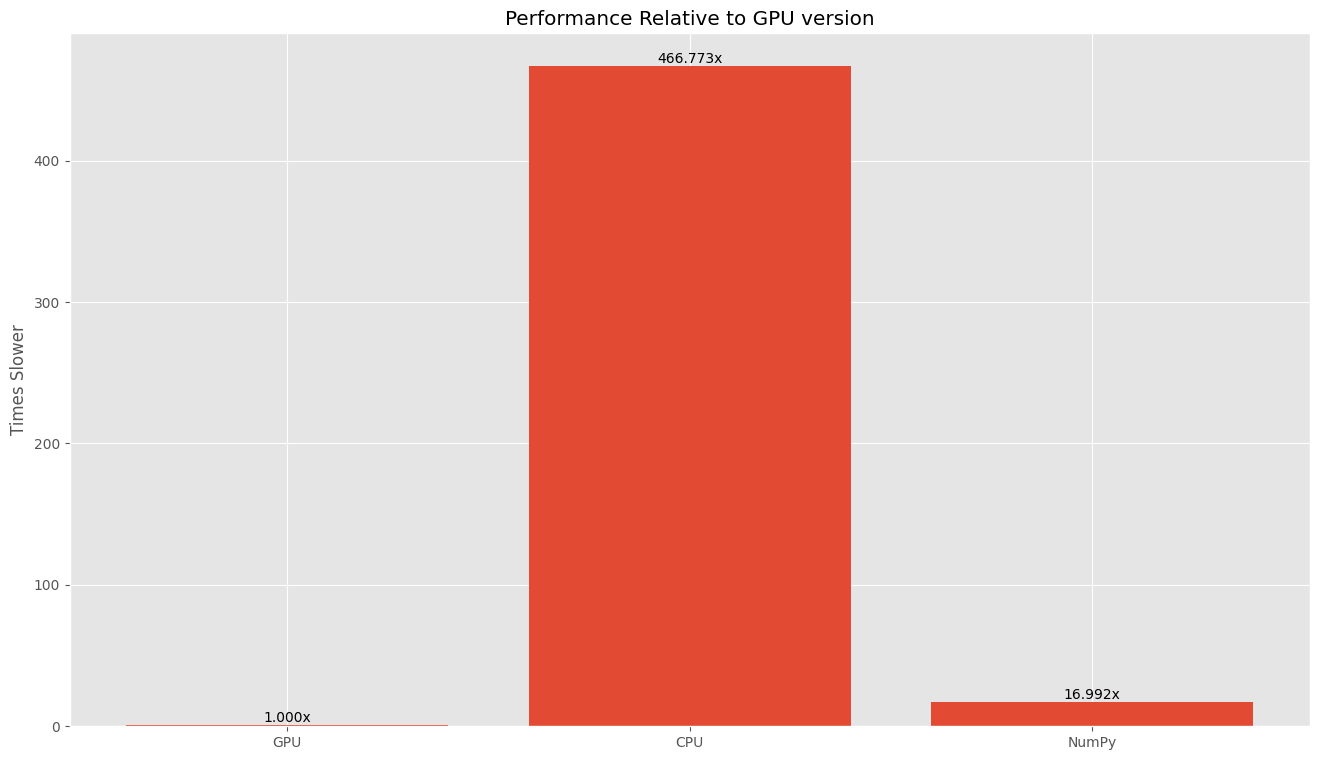

In [68]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize = (16,9))
    ax = fig.add_subplot(1, 1, 1)
    rects = ax.bar(
        ["GPU", "CPU", "NumPy"],
        [mean_elapsed_gpu / mean_elapsed_gpu, mean_elapsed_cpu / mean_elapsed_gpu, mean_elapsed_np / mean_elapsed_gpu])
    ax.bar_label(rects, padding = 0, labels = [f"{r.get_height():.3f}x" for r in rects])
    ax.set_title("Performance Relative to GPU version")
    ax.set_ylabel(fr"Times Slower")
    plt.show()

In [70]:
# improved GPU histogram using shared array

blocks_per_grid = 32 * 76
threads_per_block = 128

@cuda.jit
def shared_ascii_count_histogram_gpu(str_in_ascii_arr, ascii_val_arr):
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    local_histo = cuda.shared.array(shape = 128, dtype = nb.int64)
    local_histo[cuda.threadIdx.x] = 0
    cuda.syncthreads()

    for i in range(thread_idx, str_in_ascii_arr.size, stride):
        if str_in_ascii_arr[i] < 128:
            cuda.atomic.add(local_histo, str_in_ascii_arr[i], 1)
    cuda.syncthreads()

    cuda.atomic.add(ascii_val_arr, cuda.threadIdx.x, local_histo[cuda.threadIdx.x])
    # don't need cuda.syncthreads() at the end since it is a atomic function, one thread at a time read and writing

In [78]:
blocks_per_grid = 32 * 76
threads_per_block = 128

str_bill_arr_gpu = cuda.to_device(str_bill_arr)
ascii_val_arr_gpu = cuda.device_array(shape = 128, dtype = np.int64)
stream = cuda.stream()

n = 10000
event_start_lst = []
event_end_lst = []
for _ in trange(n):
    event_start = cuda.event()
    event_end = cuda.event()
    event_start.record(stream = stream)
    ascii_kernel[1, 128, stream](ascii_val_arr_gpu)
    shared_ascii_count_histogram_gpu[blocks_per_grid, threads_per_block, stream](str_bill_arr_gpu, ascii_val_arr_gpu)
    event_end.record(stream = stream)

    event_start_lst.append(event_start)
    event_end_lst.append(event_end)
stream.synchronize()
shared_elapsed_gpu_lst = [e0.elapsed_time(e1) for (e0, e1) in list(zip(event_start_lst, event_end_lst))]
mean_shared_elapsed_gpu = np.mean(shared_elapsed_gpu_lst)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 10000/10000 [00:01<00:00, 9760.34it/s]


In [79]:
mean_shared_elapsed_gpu

np.float64(0.09358230919837951)

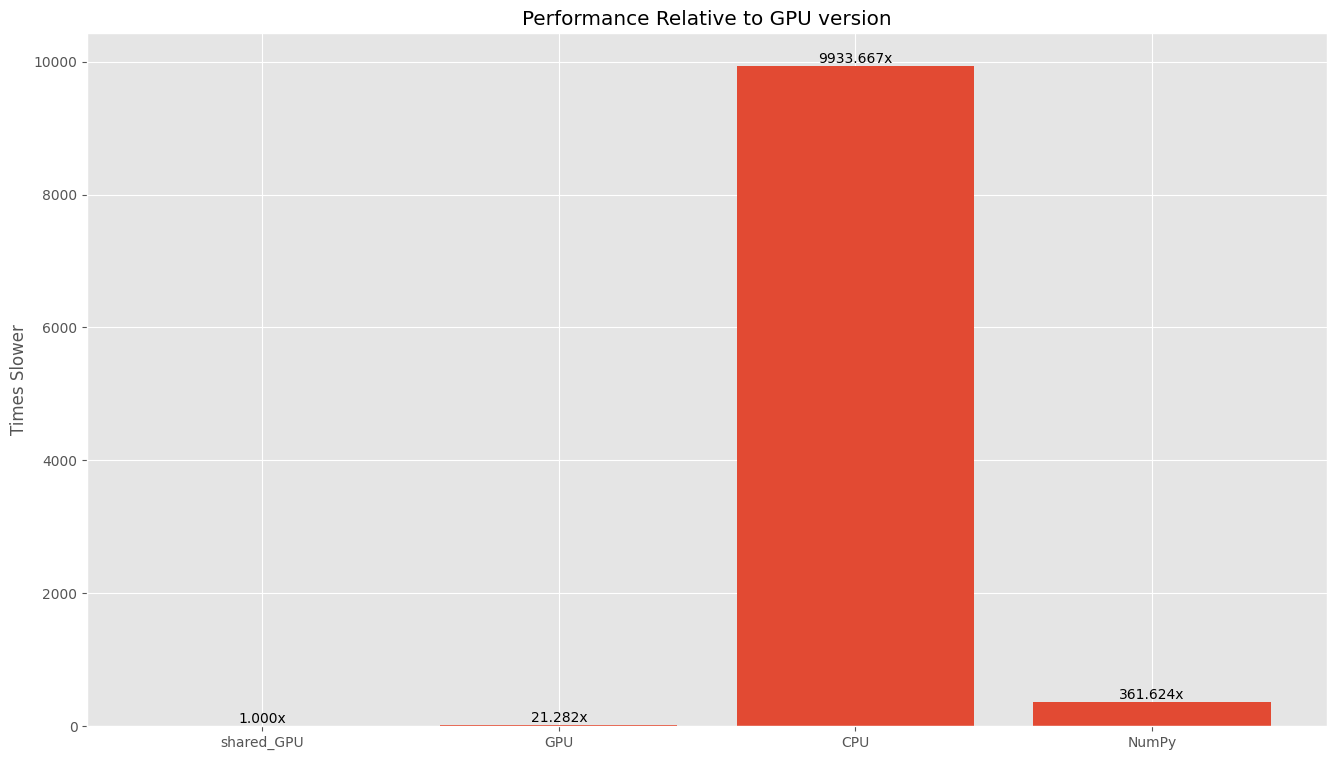

In [81]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize = (16,9))
    ax = fig.add_subplot(1, 1, 1)
    rects = ax.bar(
        ["shared_GPU", "GPU", "CPU", "NumPy"],
        [1, mean_elapsed_gpu / mean_shared_elapsed_gpu, mean_elapsed_cpu / mean_shared_elapsed_gpu, mean_elapsed_np / mean_shared_elapsed_gpu])
    ax.bar_label(rects, padding = 0, labels = [f"{r.get_height():.3f}x" for r in rects])
    ax.set_title("Performance Relative to GPU version")
    ax.set_ylabel(fr"Times Slower")
    plt.show()

In [3]:
# Dot Product
blocks_per_grid = 4 * 76
threads_per_block = 1024


@cuda.jit
def partial_dot(a, b, partial_dot_res):
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    thread_dot = 0.0
    for i in range(thread_idx, a.size, stride):
        dot_i = a[i] * b[i]
        thread_dot += dot_i
    
    dot_block = cuda.shared.array(shape = threads_per_block, dtype = nb.int64)
    dot_block[cuda.threadIdx.x] = thread_dot
    cuda.syncthreads()

    j = cuda.blockDim.x // 2
    while j != 0:
        if cuda.threadIdx.x < j:
            dot_block[cuda.threadIdx.x] += dot_block[cuda.threadIdx.x + j]
        cuda.syncthreads()
        j = j // 2
    
    if cuda.threadIdx.x == 0:
        partial_dot_res[cuda.blockIdx.x] = dot_block[0]
        # we dont need syncthreads here since only one thread from each block will write to partial_dot_res
        # they also write to different indexes of partial_dot-res -> no race condition
        # if they have to write to the same parts of the global array -> use atomics

@cuda.jit
def dot_sum(partial_dot_res, final_res):
    thread_idx = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    for i in range(thread_idx, partial_dot_res.size, stride):
        cuda.atomic.add(final_res, 0, partial_dot_res[i])

In [4]:
np.linalg.multi_dot(
    (np.arange(0, 50_000), np.arange(50_000, 100_000))
)

np.int64(104164166675000)

In [98]:
4*76

304

In [5]:
a_gpu = cuda.to_device(np.arange(0, 50_000).astype(np.int64))
b_gpu = cuda.to_device(np.arange(50_000, 100_000).astype(np.int64))
partial_dot_gpu = cuda.device_array(shape = blocks_per_grid, dtype = np.int64)
dot_gpu = cuda.device_array(shape = 1, dtype = np.int64)

partial_dot[blocks_per_grid, threads_per_block](a_gpu, b_gpu, partial_dot_gpu)
dot_sum[1, blocks_per_grid](partial_dot_gpu, dot_gpu)

dot_cpu = dot_gpu.copy_to_host()

/home/alvinng44/.local/share/mamba/envs/alyssa/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [6]:
dot_cpu[0] == np.linalg.multi_dot(
    (np.arange(0, 50_000), np.arange(50_000, 100_000))
)

np.True_